In [1]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
import plot_utils as pu
import skytools as st

In [16]:
fg_path = f'/global/cfs/cdirs/cmb/gsharing/panexp_v1_planck/galactic_foregrounds_mediumcomplexity/'
npipe_path = f'/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/'

In [3]:
freq = 353
lmax = 100
hfi_sim = st.change_resolution(hp.read_map(f'{fg_path}sobs_mbs-s0017-20250208_HFI_mission_{freq:03}_galactic_foregrounds_mediumcomplexity_healpix.fits', field=None), nside_out=128, lmax_sht=lmax, mode='iqu', fwhm_in=5., fwhm_out=2.)

In [17]:
freq = 353
lmax = 100
hfi_npp = st.change_resolution(hp.read_map(f'{npipe_path}npipe6v20_{freq:03}_map.fits', field=(0,1,2)), nside_out=128, lmax_sht=lmax, mode='iqu', fwhm_in=5., fwhm_out=2.) * 1e6
rot = hp.Rotator(coord=['G','C'])
hfi_npp = rot.rotate_map_alms(hfi_npp, lmax=lmax)

In [5]:
polI_sim = np.sqrt(hfi_sim[1]**2 + hfi_sim[2]**2)
polI_npp = np.sqrt(hfi_npp[1]**2 + hfi_npp[2]**2)

In [6]:
mask = st.intensity_mask(128, polI_npp, 3., smooth_in_deg=1.)

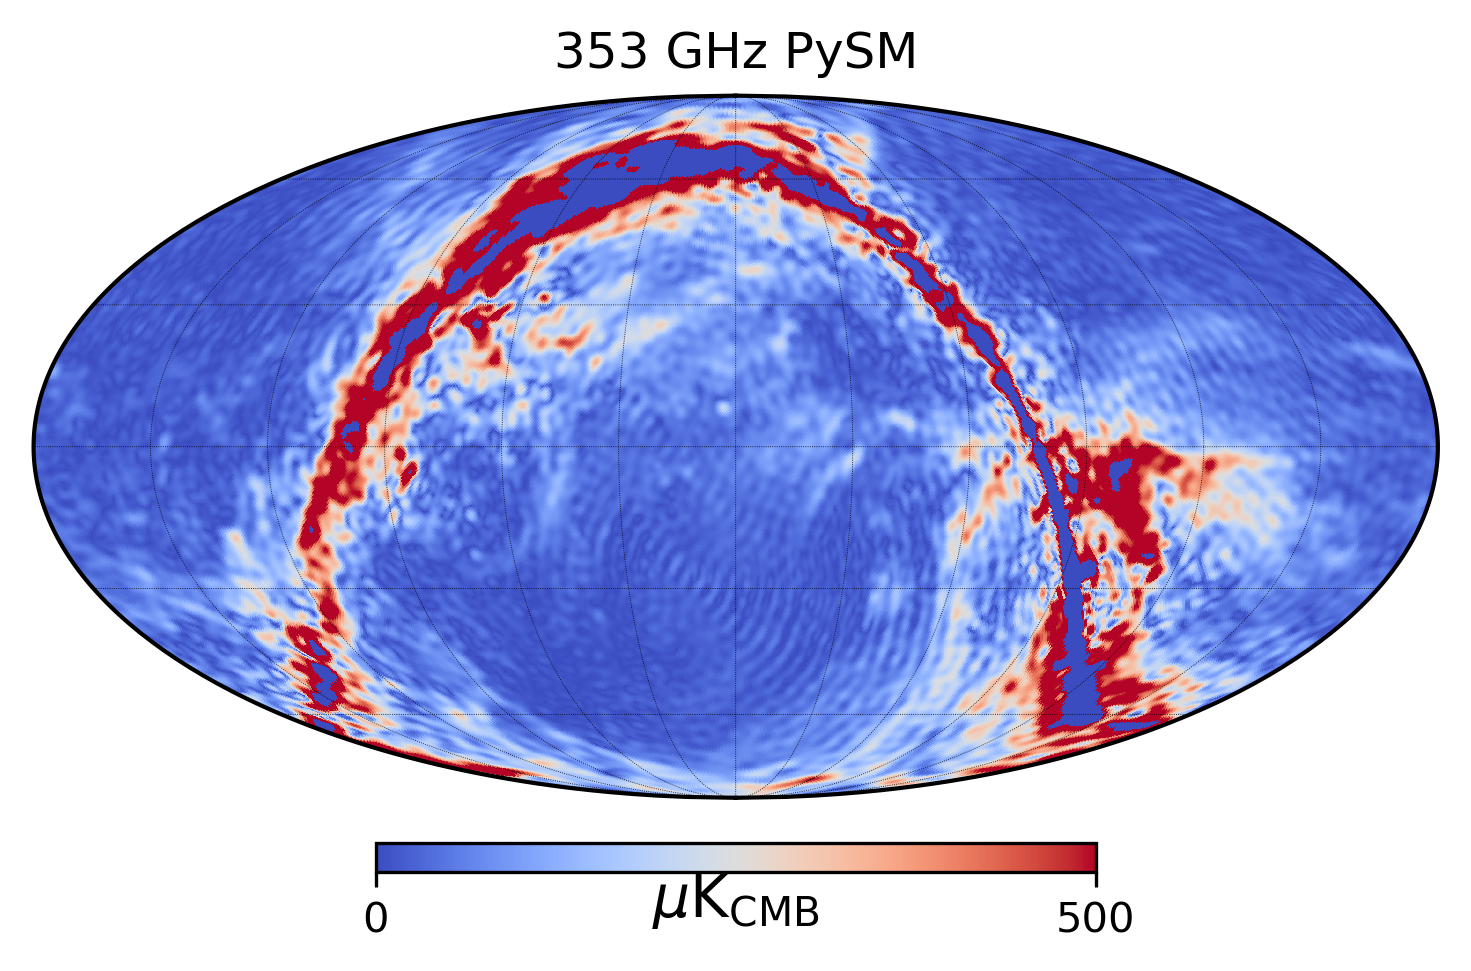

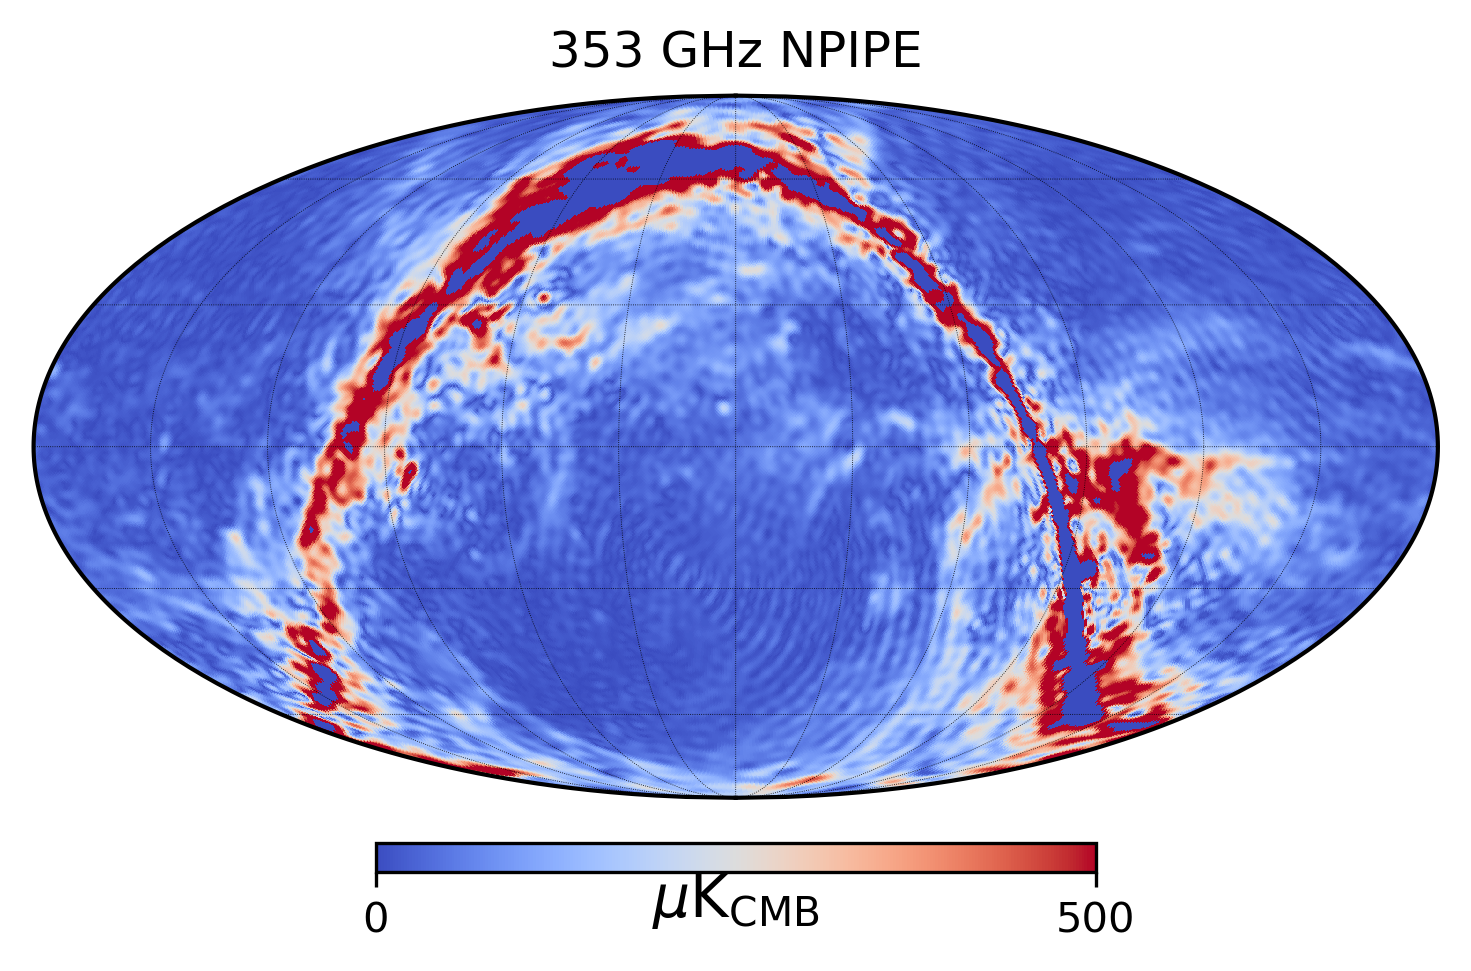

In [7]:
pu.hires_mollview(polI_sim*mask, vmin=0, vmax=500, title=f'353 GHz PySM')
pu.hires_mollview(polI_npp*mask, vmin=0, vmax=500, title=f'353 GHz NPIPE')

Text(0, 0.5, 'PySM d10 353 GHz pol Intensity')

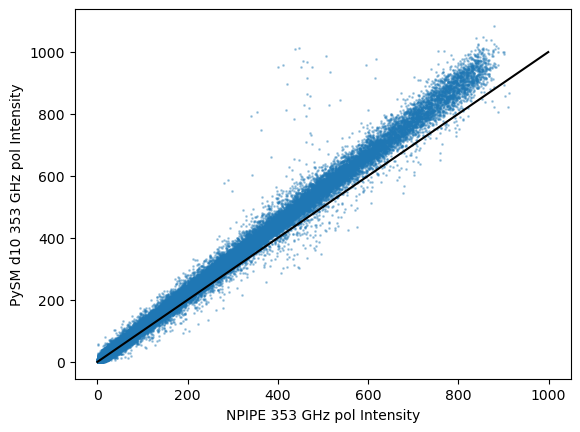

In [8]:
x = np.arange(0, 1000)
plt.plot(polI_npp[mask > 0.5], polI_sim[mask > 0.5], 'o', alpha=0.33, ms=1.0)
plt.plot(x, x, 'k-')
plt.xlabel('NPIPE 353 GHz pol Intensity')
plt.ylabel('PySM d10 353 GHz pol Intensity')


In [9]:
Bmode_sim = st.iqu2teb(hfi_sim*mask, mode='b', lmax_sht=lmax)
Bmode_npp = st.iqu2teb(hfi_npp*mask, mode='b', lmax_sht=lmax)

Text(0, 0.5, 'PySM d10 353 GHz B-mode map')

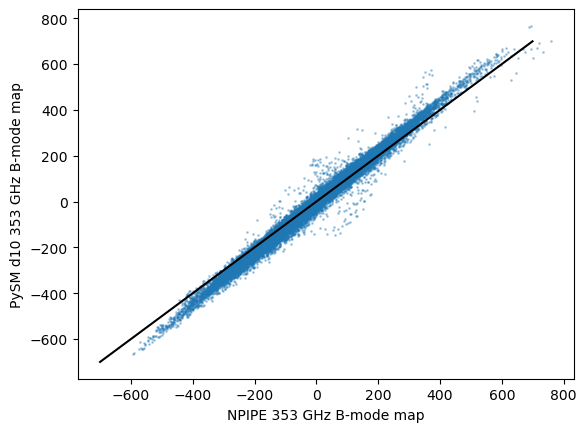

In [11]:
x = np.arange(-700, 700)
plt.plot(Bmode_npp[0, mask > 0.5], Bmode_sim[0, mask > 0.5], 'o', alpha=0.33, ms=1.0)
plt.plot(x, x, 'k-')
plt.xlabel('NPIPE 353 GHz B-mode map')
plt.ylabel('PySM d10 353 GHz B-mode map')